Read in all libraries

In [1]:
#all imports

import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import scipy
import scipy.stats as stats
import scipy.integrate
from scipy.stats import norm
from scipy.optimize import curve_fit
import scipy.stats as scs
from astropy.modeling import models, fitting

Define all required functions.
Note that I changed the rand_num_gen so that it will never return the first or last pixel

In [2]:
def rand_num_gen():
    #border: ln[3] was the original random_num_gen() 
    #border is the number of desired pixels/ number of required surrounding pixels based on electron cloud/ pixel length ratio
    photon_x = random.uniform(border*pix_L, ((num_pix_x - border) * pix_L)) #microns
    photon_y = random.uniform(border*pix_L, ((num_pix_x - border) * pix_L)) #microns
    return photon_x, photon_y

In [3]:
#def rand_num_gen():
#    photon_x = random.random() * (num_pix_x) * pix_L + pix_L #microns
#    photon_y = random.random() * (num_pix_y) * pix_L + pix_L #microns
#    return photon_x, photon_y

In [4]:
def find_closest_pix(photon_x, photon_y):
    closest_pix_x = (np.where(np.abs(detector_x - photon_x) == np.min(np.abs(detector_x - photon_x))))[0]
    closest_pix_x = closest_pix_x[0]
    closest_pix_y = (np.where(np.abs(detector_y - photon_y) == np.min(np.abs(detector_y - photon_y))))[0]
    closest_pix_y = closest_pix_y[0]
    return(closest_pix_x, closest_pix_y)

In [5]:
def ghost_cell():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #xtr_)row/col is the number of rows or columns needed to fit the entire photon in the array
        #xtr_row = xtr_col = (math.ceil((e_cloud * (1/2)) / pix_L)) defined at top
        #redefine detector size to fit
        detector = np.zeros((num_pix_x + xtr_row*2, num_pix_y + xtr_col*2))
        detector_x = np.arange(num_pix_x + xtr_row) * pix_L + pix_half_L
        detector_y = np.arange(num_pix_y + xtr_col) * pix_L + pix_half_L
        return detector, detector_x, detector_y
        print('photon fell too close to edge of detector for the graph we wrote to work. Added extra layer of dead pixels to help?')
    else:
        print('no imshow problems')

In [6]:
def zero_ghost_cells():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #they will be erased
        #xtr_row = xtr_col = 2 * (math.ceil((e_cloud * (1/2)) / pix_L)) defined at top
        detector[0:xtr_row,] = 0 #top
        detector[-xtr_row:,] = 0 #bottom
        detector[:,0:xtr_col] = 0 #left
        detector[:,-xtr_col:] = 0 #right
        print('photon fell too close to edge of detector. Brought ghost cell values to zero.')
        return detector
    else:
        print('didnt work')

In [7]:
def gaus_noise():
    #np.random.normal(mean noise, std dev, size of array)
    #had to make an if statement in case the array is larger for ghost cells
    #if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
    #    detector += np.random.normal(loc = mean, scale = std_dev, size = (num_pix_x + xtr_row * 2, num_pix_y + xtr_col *2))
    #else:
    #loc = mean
    noise_array = np.random.normal(loc = mean, scale = std_dev, size = (num_pix_x, num_pix_y))
    return noise_array

In [8]:
def integrate_setup():
#Whenever you see an error that include 'NoneType' that means that you have an operand or an object that is None when you were expecting something else.
#num_subpix is the number in x & y (rows and columns) they are always equal because the photon will always be a circle
    #subpix_x_cen, subpix_y_cen, subpix_z_cen, subpix_arr = integrate_setup()
    subpix_arr = np.zeros((num_subpix_x, num_subpix_y, num_subpix_z))
    subpix_x_cen = np.arange(num_subpix_x) * subpix_L + (detector_x[int(closest_pix_x - start_pix)] - pix_half_L) + subpix_L
    subpix_y_cen = np.arange(num_subpix_y) * subpix_L + (detector_y[int(closest_pix_y - start_pix)] - pix_half_L) + subpix_L  
    subpix_z_cen = np.arange(num_subpix_z) * subpix_L
    return subpix_arr, subpix_x_cen, subpix_y_cen, subpix_z_cen

In [9]:
#this can hypothitically done at the beginning (or anywhere before the plot really...)
#this function does not rely on any other functions -- it will also remain the same for the same pixel/e_cloud sizes
def find_num_pix_plt(num_pix_plt):
    if num_pix_plt % 2 == 0:
        num_pix_plt += 3
    else:
        num_pix_plt += 2
    return num_pix_plt

In [10]:
def sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen):
    for i in range(num_subpix_x):
        for j in range(num_subpix_y):
            for k in range(num_subpix_z):
                dist_cen_photon = np.sqrt((subpix_x_cen[i] - photon_x)**2 + \
                                                (subpix_y_cen[j] - photon_y)**2 + \
                                                (subpix_z_cen[k] - photon_z)**2)
#the entire electron will be contained within a pixel if the distance from center of photon is less than half the e_cloud diameter
                if dist_cen_photon < e_cloud / 2:
                    subpix_arr[i,j,k] = 1
    return subpix_arr
#dist_cen_photon = sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen)

In [11]:
def each_pix_e(closest_pix_x, closest_pix_y):
    for ii in range(int(closest_pix_x - start_pix), int(closest_pix_x + (num_pix_plt - start_pix))):
        for jj in range(int(closest_pix_y - start_pix), int(closest_pix_y + (num_pix_plt - start_pix))):
            left_edge = edge_x[ii]
            right_edge = edge_x[ii + 1] 
            bottom_edge = edge_y[jj]
            top_edge = edge_y[jj + 1] 
            #gives us 1st element to sum over
            #>= <= allows us to account for the pixels landing on the edge
            match_x0 = np.where (subpix_x_cen >= left_edge)[0][0]
            #[0][-1] -1 means take the last numbre of the array
            match_x1 = np.where (subpix_x_cen <= right_edge)[0][-1]
            match_y0 = np.where (subpix_y_cen >= bottom_edge)[0][0]
            match_y1 = np.where (subpix_y_cen <= top_edge)[0][-1]
            this_pct = np.sum(img[match_x0:match_x1, match_y0:match_y1]) / np.sum(img)
            #with more photons continue to += 
            detector[ii, jj] += this_pct * e_per_photon
            #print(detector[ii,jj])

In [12]:
#imgplot is a zoomed in 2D visualization of a 3D photon hitting the sensor
#this cell is making the imshow graph/ image
#img = is the integration #voxel = 3D pixel

def e_cloud_plt():
    subpix_arr = integrate_setup()
    img = np.sum(subpix_arr, axis=0)
    imgplot = plt.imshow(img)
    plt.grid(True)
    plt.axis([0, num_subpix_x , 0, num_subpix_y])
    #subpix size tells the program how exact we want our calculations. how many pieces of the pixel are we accounting for
    #*** shows 90 as past the border. also check the subpix defined edges, why not just full pixels?
    plt.title('Magnified detector showing where photon hit')
    plt.xlabel('number of subpixels')
    plt.ylabel('number of subpixels')
    plt.axis(aspect = 'img')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, num_subpix_x, num_subpix_x / num_pix_plt))
    ax.set_yticks(np.arange(0, num_subpix_y, num_subpix_y / num_pix_plt))
    plt.colorbar(label='Number of Electrons (charge)')
    plt.show()
    return img, imgplot


In [13]:
def delete_ghost():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #axis : Axis along which we want to delete. If 1 then dlete columns, if 0 then delete rows and if None then app4ly delete on flattened array.
        np.delete(detector, [0,xtr_row], axis = 0) #top
        np.delete(detector, [num_pix_x+xtr_row*2-xtr_row,], axis = 0) #bottom
        np.delete(detector, [0,xtr_col], axis = 1) #left
        np.delete(detector, [num_pix_x+xtr_col*2-xtr_col,], axis = 1) #right
        return detector
    else:
        None

Set up specific variables for hte run

In [14]:
pix_L = 15 #microns
pix_half_L = pix_L / 2
num_pix_x = 100
num_pix_y = 100
e_per_photon = 1500 #electrons
subpix_L = 1 #microns #this number just determines the img quality (how pixellated)
e_cloud = 5 #microns diameter
gain = 2 #electrons/DN
#this is the number of desired photons hitting the detector,
num_photon = 1000 #how many photons do you want to hit the sensor
bias = 1000 #electrons base voltage
mean = 0 #for histogram gaus distribution
std_dev = 25 #gaussian noise added to each pixel np.random.normal = gaussian could also name this variable g_noise
photon_z = int(e_cloud / 2) +2 #***will eventually be changed
xtr_row = xtr_col = math.ceil((e_cloud * (1/2)) / pix_L)
num_pix_plt = find_num_pix_plt(math.ceil(e_cloud / pix_L))
#num_pix_plt = math.ceil(e_cloud / pix_L)
border = math.floor(num_pix_plt / 2) #this shows us the minimum border needed so the pixels don't get cut off
#the border wasnt really the problem, but it could be, so applying minimum border
start_pix = (num_pix_plt - 1) / 2
num_subpix = num_subpix_x = num_subpix_y = round((pix_L * num_pix_plt) / subpix_L)
num_subpix_z = photon_z * 2 #*** will need to be fixed/removed later

In [15]:
#defining initial array representation of detector
#this does not need to be a function: everything is applied to this single detector:
detector = np.zeros((num_pix_x, num_pix_y))
detector_x = np.arange(num_pix_x) * pix_L + pix_half_L
detector_y = np.arange(num_pix_y) * pix_L + pix_half_L
cen_x = np.arange(num_pix_x) * pix_L + pix_half_L
cen_y = np.arange(num_pix_y) * pix_L + pix_half_L
edge_x = np.arange(num_pix_x + 1) * pix_L
edge_y = np.arange(num_pix_y + 1) * pix_L

1500000.0


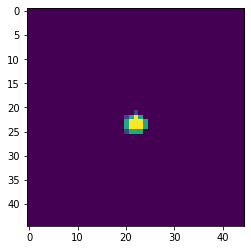

In [16]:
for ph in range(0,num_photon):
    photon_x, photon_y = rand_num_gen()
    closest_pix_x, closest_pix_y = find_closest_pix(photon_x, photon_y)
    #print((closest_pix_x, closest_pix_y))
    subpix_arr, subpix_x_cen, subpix_y_cen, subpix_z_cen = integrate_setup()
    subpix_arr = sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen)
    img = (np.sum(subpix_arr,axis=2))
    plt.imshow(img)
    each_pix_e(closest_pix_x, closest_pix_y)
print(np.sum(detector))

In [17]:
check_tot_e = np.sum(detector) #+ bias * num_pix_x **2
if (check_tot_e == e_per_photon*num_photon):
    print('No rounding error. total number of electrons = ' + str(e_per_photon * num_photon))
else:
    print('***ROUNDING ERROR: total number of electrons is != ' + str(e_per_photon * num_photon) + ". It is = " + str(check_tot_e))

No rounding error. total number of electrons = 1500000


In [18]:
#adds the chosen bias to every value in the detector
for ii in range(num_pix_x):
    for jj in range (num_pix_y):
        detector[ii,jj] = detector[ii,jj] + bias 
#plt.imshow(detector)
#help(detector)

In [19]:
#adds gaussian noise with chosen standard deviation and mean (centroid)
noise_array = gaus_noise()
detector = detector + noise_array

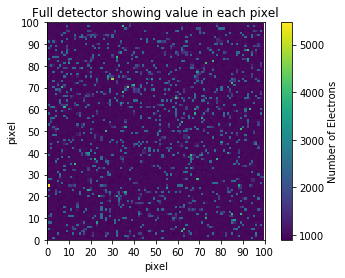

In [20]:
#to make this plot correctly we needeed to define the ticks as a LIST
x_tick_label = (np.arange(0, num_pix_x+1, step = 10))
y_tick_label = (np.arange(0, num_pix_y+1, step = 10))
x_tick_label.tolist()

plt.imshow(detector)
plt.axis([0, num_pix_plt, 0, num_pix_plt])
plt.title('Full detector showing value in each pixel')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='Number of Electrons')
#plt.axis(aspect = 'img')
ax = plt.gca()
plt.xticks(x_tick_label)
plt.yticks(y_tick_label)
plt.xlim(0,num_pix_x)
plt.ylim(0,num_pix_y)
ax.set_xticklabels(x_tick_label)
ax.set_yticklabels(y_tick_label)
plt.show();
#after converted to data number
#descretize/ digitize
#tot # of charge has to be int
#ask amy if we want to >1 or >1.4 etc
#(math.ceil)
#this is what the gain conv does!

In [21]:
if (np.sum(detector) == (e_per_photon*num_photon + bias*num_pix_x*num_pix_y)):
    print('no problem')
else:
    print('error: sum of detector did not result in expected value: actual sum of detector ' + (str(np.sum(detector))) + ' expected sum: ' + str((e_per_photon*num_photon + bias*num_pix_x*num_pix_y)) + ' + gaussian noise.')

error: sum of detector did not result in expected value: actual sum of detector 11498536.413075976 expected sum: 11500000 + gaussian noise.


In [22]:
#we need to flatten the detector bc it is a 3D array 
flat_det = detector.flatten() 
bin_div = 5
#***ask if this is OK? can we have different bin sizes?
num_bins = int(((bias+4*std_dev+e_per_photon) - (bias-4*std_dev)) / bin_div)
#effectively range of the detector / bin_divisor

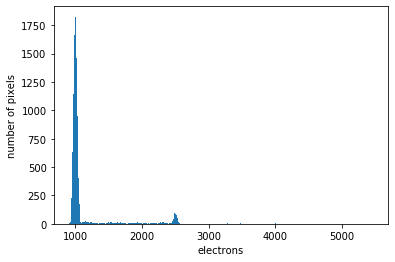

In [50]:
bin_heights, bin_boundaries, _ = plt.hist(flat_det, bins = num_bins)
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.show();

all_but_first = bin_boundaries[1:]
all_but_last = bin_boundaries[:-1]  

bin_midpoints = (all_but_first + all_but_last) / 2
#full histogram with bias and signal bumps

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude  mean  stddev
    --------- ------ ------
       1700.0 1000.0   25.0
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    1817.9464589256947 1000.2076782058252 25.39337774001558
[ 902.31535992  904.61953826  906.9237166   909.22789495  911.53207329
  913.83625163  916.14042997  918.44460831  920.74878665  923.05296499
  925.35714334  927.66132168  929.96550002  932.26967836  934.5738567
  936.87803504  939.18221338  941.48639173  943.79057007  946.09474841
  948.39892675  950.70310509  953.00728343  955.31146178  957.61564012
  959.91981846  962.2239968   964.52817514  966.83235348  969.13653182
  971.44071017  973.74488851  976.04906685  978.35324519  980.65742353
  982.96160187  985.26578021  987.56995856  989.8741369   992.17831524
  994.48249

(900, 1100)

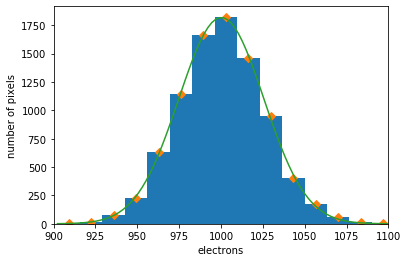

In [54]:
# Bias fit block

gaus_guess = models.Gaussian1D(amplitude=1700, mean=bias, stddev=std_dev)
print(gaus_guess)
gaus_fitter = fitting.LevMarLSQFitter()
bias_range = np.where(bin_midpoints<bias + 6 * std_dev)

fitted_gaus_bias = gaus_fitter(gaus_guess, bin_midpoints[bias_range], bin_heights[bias_range])
print(fitted_gaus_bias)
#this works, it is returning ~ the correct answer

x_bias = np.linspace(start = np.min(bin_boundaries[bias_range]), stop = np.max(bin_boundaries[bias_range]), num = 100,)

plt.hist(flat_det, bins = num_bins)
#plt.ylim(0, 250)
plt.plot(bin_midpoints, bin_heights, "D") #this line puts the orange diamonds at the midpoint & top of every bar
plt.plot(x_bias, fitted_gaus_bias(x_bias)) #this line adds green normal curve
plt.xlabel('electrons')
plt.ylabel('number of pixels')
print(x_bias)
plt.xlim(bias-4*std_dev, bias+4*std_dev)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude            mean             stddev      
    ---------------- ----------------- ------------------
    95.3137877273573 2497.598950576954 28.899225268876716
[ 902.31535992  904.61953826  906.9237166   909.22789495  911.53207329
  913.83625163  916.14042997  918.44460831  920.74878665  923.05296499
  925.35714334  927.66132168  929.96550002  932.26967836  934.5738567
  936.87803504  939.18221338  941.48639173  943.79057007  946.09474841
  948.39892675  950.70310509  953.00728343  955.31146178  957.61564012
  959.91981846  962.2239968   964.52817514  966.83235348  969.13653182
  971.44071017  973.74488851  976.04906685  978.35324519  980.65742353
  982.96160187  985.26578021  987.56995856  989.8741369   992.17831524
  994.48249358  996.78667192  999.09085026 1001.39502861 1003.69920695
 1006.00338529 1008.30756363 1010.61174197 1012.91592031 1015.22009865
 1017.524277   1019.82845534 1022.1326

(0, 200)

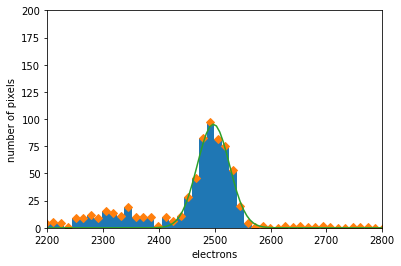

In [57]:
# Signal fit block

signal_range = np.where(bias + 6 * std_dev<bin_midpoints)
gaus_guess = models.Gaussian1D(amplitude=100, mean=2500, stddev=std_dev)
fitted_gaus_signal = gaus_fitter(gaus_guess, bin_midpoints[signal_range], bin_heights[signal_range])
print(fitted_gaus_signal)
x_signal = np.linspace(start = 2200, stop = 2800, num = 100,)

plt.hist(flat_det, bins = num_bins)
#plt.ylim(0, 250)
plt.plot(bin_midpoints, bin_heights, "D") #this line puts the orange diamonds at the midpoint & top of every bar
plt.plot(x_signal, fitted_gaus_signal(x_signal)) #this line adds green normal curve
plt.xlabel('electrons')
plt.ylabel('number of pixels')
print(x_bias)
plt.xlim(2200,2800)
plt.ylim(0,200)

In [36]:
hist, bin_edges = np.histogram(flat_det, bins=num_bins)
hist
print(max(hist))
#print(hist)
#print(bin_edges)
print(max(hist[15:]))

1825
97


[ 902.31535992  948.39892675  994.48249358 1040.56606041 1086.64962724
 1132.73319407 1178.8167609  1224.90032773 1270.98389456 1317.06746139
 1363.15102822 1409.23459505 1455.31816188 1501.40172871 1547.48529554
 1593.56886237 1639.6524292  1685.73599603 1731.81956286 1777.90312969
 1823.98669652 1870.07026335 1916.15383018 1962.23739701 2008.32096385
 2054.40453068 2100.48809751 2146.57166434 2192.65523117 2238.738798
 2284.82236483 2330.90593166 2376.98949849 2423.07306532 2469.15663215
 2515.24019898 2561.32376581 2607.40733264 2653.49089947 2699.5744663
 2745.65803313 2791.74159996 2837.82516679 2883.90873362 2929.99230045
 2976.07586728 3022.15943411 3068.24300094 3114.32656777 3160.4101346
 3206.49370143 3252.57726826 3298.66083509 3344.74440192 3390.82796875
 3436.91153558 3482.99510241 3529.07866924 3575.16223607 3621.2458029
 3667.32936973 3713.41293656 3759.49650339 3805.58007022 3851.66363705
 3897.74720388 3943.83077071 3989.91433754 4035.99790437 4082.0814712
 4128.165038

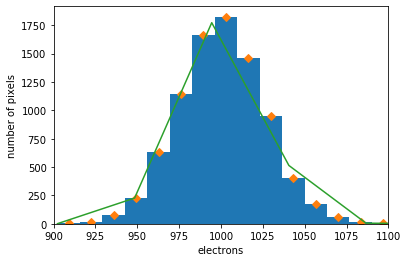

(Parameter('amplitude', value=1817.9522173690666),
 Parameter('mean', value=1000.2076379916267),
 Parameter('stddev', value=25.393207897966526, bounds=(1.1754943508222875e-38, None)))

In [38]:
bin_heights_sign, bin_boundaries_sign, _ = p

#plt.ylim(0, max(hist)+50)
plt.show();
#Fig below is zoomed in to see the signal peak
#it also has a different number of bins bc depending on which peak we look at
#***ask if this is OK? can we have different bin sizes?
#We define the bias +gaus noise curve to be +- 4 std_dev
#graph below shows the data between +- 4*std_dev and plots a normal curve on it
fitted_gaus_bias.amplitude, fitted_gaus_bias.mean, fitted_gaus_bias.stddev

In [ ]:
#norm_bias = np.linspace(bias - 4 * std_dev, bias + 4 * std_dev, 100)
#plt.plot(norm_bias, height_bias* stats.norm.pdf(norm_bias, bias, std_dev))
#norm_signal = np.linspace(bias + e_per_photon - 4 * std_dev, bias + e_per_photon + 4 * std_dev, 100)
#plt.plot(norm_signal, (height_signal* stats.norm.pdf(norm_signal, bias + e_per_photon, std_dev)))
plt.hist(flat_det, bins = num_bins)
plt.plot(bin_midpoints, bin_heights, "D")
plt.plot(x_signal, fitted_gaus_signal(x_signal))
#plt.xlim(bias+4*std_dev, bias+e_per_photon+6*std_dev)
plt.xlim(2400, 2600)
plt.ylim(0, max(hist[13:])+10)
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.show();
fitted_gaus_signal.amplitude, fitted_gaus_signal.mean, fitted_gaus_signal.stddev
#This plot is the 
#>6sigma
#different bin size
#what would you do to get the gain from hist?

In [ ]:
#fit_mean_bias, fit_std_dev_bias = stats.distributions.norm.fit(flat_det[900 : 1100]) rough estimate for std_dev = 25
fit_mean_bias, fit_std_dev_bias = stats.distributions.norm.fit(flat_det[bias-4*std_dev : bias+4*std_dev])
print(fit_mean_bias)
print(fit_std_dev_bias)
#these numbers represent the centroid of the "bias bump"
#the slice should be from bias - 4*std_dev to bias+4*std_dev

In [ ]:
fit_mean_signal, fit_std_dev_signal = stats.distributions.norm.fit(flat_det[(bias+e_per_photon)-3*std_dev : (bias+e_per_photon)+3*std_dev])
print(bias+e_per_photon)
print(3*std_dev)
print(fit_mean_signal)
print(fit_std_dev_signal)
print(flat_det[(bias+e_per_photon)-3*std_dev : (bias+e_per_photon)+3*std_dev])

In [ ]:
plt.hist(flat_det/gain, bins = num_bins)
norm_bias = np.linspace(bias - 4 * std_dev, bias + 4 * std_dev, 100)
#plt.plot(norm_bias, height_bias* stats.norm.pdf(norm_bias, bias, std_dev))
norm_signal = np.linspace(bias + e_per_photon - 4 * std_dev, bias + e_per_photon + 4 * std_dev, 100)
#plt.plot(norm_signal, (height_signal* stats.norm.pdf(norm_signal, bias + e_per_photon, std_dev)))
plt.ylim(0, 60)
plt.xlabel('DN')
#plt.legend()
#plt.grid(True)
plt.show();
#we can get gain from this

In [ ]:
if (np.sum(detector) == (e_per_photon*num_photon + bias*num_pix_x*num_pix_y)/gain):
    print('no problem')
else:
    print('error: sum of detector did not result in expected value: actual sum of detector ' + (str(np.sum(detector))) + 'expected sum: ' + str((e_per_photon*num_photon + bias*num_pix_x*num_pix_y)/gain))